# CNN for the classification of the MNIST dataset

## Required library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical



2021-12-08 23:11:58.174706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 23:11:58.174756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load dataset and normalize data

In [2]:
#Load dataset
data = pd.read_csv('Mnist-digit/mnist.csv')
y=data.pop('label')
x=data
x=x.values.reshape((-1,28,28,1)) /255.0 # normalize data

## Train-Test Split

In [3]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0)
sss.get_n_splits(x, y)
print(sss)

for train_index, test_index in sss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.33,
            train_size=None)
TRAIN: [30512  3538 40571 ... 31149 25562 30468] TEST: [18527 12538 34481 ... 35846 26037  6952]
TRAIN: [ 4806 20259 31193 ... 30115 26552 19138] TEST: [13022 10452 32436 ... 21135 34707 14791]
TRAIN: [38342 19007  3097 ...  7655 37617 23869] TEST: [23472 36446 29580 ... 25953  6950 38604]
TRAIN: [34245  2197 41386 ... 26851 36067 37364] TEST: [ 4778 16086 27235 ...  3346  6073 35709]
TRAIN: [ 1605 37376 38709 ... 20374 26388 24728] TEST: [21681 14258 24661 ... 40966 17466 22461]


## Data vis

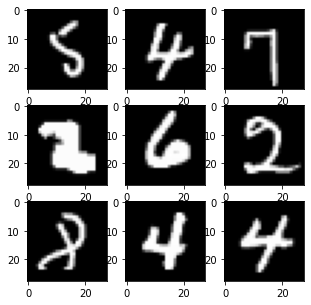

In [4]:
plt.figure(figsize=(5,5))
for i in range(9):  
    plt.subplot(3,3, i+1)
    plt.imshow(x_train[i],cmap='gray')
plt.show()

## One Hot Encoding

In [5]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


## Define Model

In [6]:
keras.backend.clear_session()
model = keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
                            input_shape=(x_train.shape[1:])))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=10, activation='softmax', 
                       kernel_regularizer=keras.regularizers.L2(0.001)))



2021-12-08 23:12:09.980938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 23:12:09.980992: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 23:12:09.981016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (920bc14734ab): /proc/driver/nvidia/version does not exist
2021-12-08 23:12:09.981223: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## compile model

In [11]:
# compile model
# loss = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.003),
              loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

## Data augmentation

In [8]:
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

## Train model

In [12]:
BS = 8
EPOCHS = 25
his = model.fit(
x=aug.flow(x_train, y_train, batch_size=BS),
validation_data=(x_test, y_test),
steps_per_epoch=len(x_train) // BS,
epochs=EPOCHS)

Epoch 1/25
3517/3517 [==============================] - 58s 16ms/step - loss: 1.2676 - accuracy: 0.5635 - val_loss: 0.4261 - val_accuracy: 0.8515
Epoch 2/25
3517/3517 [==============================] - 60s 17ms/step - loss: 0.7610 - accuracy: 0.7575 - val_loss: 0.2140 - val_accuracy: 0.9386
Epoch 3/25
3517/3517 [==============================] - 64s 18ms/step - loss: 0.6204 - accuracy: 0.8073 - val_loss: 0.1752 - val_accuracy: 0.9507
Epoch 4/25
3517/3517 [==============================] - 62s 18ms/step - loss: 0.5504 - accuracy: 0.8333 - val_loss: 0.1809 - val_accuracy: 0.9482
Epoch 5/25
3517/3517 [==============================] - 64s 18ms/step - loss: 0.4936 - accuracy: 0.8513 - val_loss: 0.1294 - val_accuracy: 0.9664
Epoch 6/25
3517/3517 [==============================] - 65s 18ms/step - loss: 0.4669 - accuracy: 0.8620 - val_loss: 0.1352 - val_accuracy: 0.9633
Epoch 7/25
3517/3517 [==============================] - 65s 18ms/step - loss: 0.4317 - accuracy: 0.8750 - val_loss: 0.1171 -

## Present Results

#### plot diagnostic learning curves

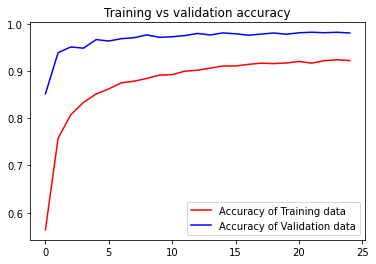

<Figure size 432x288 with 0 Axes>

In [13]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

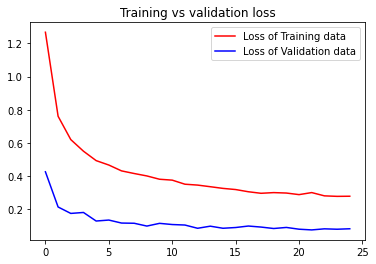

<Figure size 432x288 with 0 Axes>

In [14]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

A diagnostic plot is shown, giving insight into the learning behavior of the model across each fold. In this case, we can see that the model generally achieves a good fit, with train and test learning curves converging. There is no obvious sign of over- or underfittin


## Metrics for evaluating the performance

In [15]:
y_pred=model.predict(x_test)
pred=np.argmax(y_pred,axis=1)
y_t = np.argmax(y_test,axis=1)
print(classification_report(y_t,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1364
           1       1.00      0.99      0.99      1546
           2       0.96      0.97      0.96      1378
           3       1.00      0.98      0.99      1436
           4       0.96      0.99      0.98      1344
           5       0.97      0.96      0.97      1252
           6       0.97      0.99      0.98      1365
           7       0.97      0.99      0.98      1452
           8       0.99      0.98      0.99      1341
           9       0.99      0.96      0.97      1382

    accuracy                           0.98     13860
   macro avg       0.98      0.98      0.98     13860
weighted avg       0.98      0.98      0.98     13860

